In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import torch.nn as nn

#-------------

import poseigen_seaside.basics as se
import poseigen_seaside.visuals as viz

import poseigen_trident.preassembled as pa

In [3]:
datafolder = se.NewFolder('data')

# Data Prep

In [ ]:
inp_num = 10

snx_shared = {'dim_i': (inp_num, 1, 1),
              'P1_mods': 4, 'P1_cf_ns': 0, 
              'P1_cf_i': inp_num, 'P1_cf_pu': inp_num, 
              'batchnorm': 'before', 'activations': nn.ReLU()}

snx1 = {'dim_f': (2, 1, 1), **snx_shared}           # For data generation
snx2 = {'dim_f': (1, 1, 1), **snx_shared}           # For modelling

se.PickleDump([snx1, snx2], 'snxs')

In [5]:
pa.SimpNet(**snx1)

SimpNet(
  (P1): Sequential(
    (0): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (7): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(10, 2, kernel_size=(1, 1), stride=(1, 1), padding=valid)
  )
)

In [6]:
pa.SimpNet(**snx2)

SimpNet(
  (P1): Sequential(
    (0): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), padding=valid)
    (7): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(10, 1, kernel_size=(1, 1), stride=(1, 1), padding=valid)
  )
)

## Initial Generation
make sure both are normally distributed.

In [ ]:
# obsx = 1000000

# synth_generated = {}

# for igenr in np.arange(20):

#     SimpNetX1 = pa.SimpNet(**snx1)
#     #torch.save(SimpNetX1, datafolder + 'SimpNetX1_' + str(synth_counter) + '.pt')

#     synth_X = np.random.uniform(-1, 1, size = (obsx, *(inp_num, 1, 1)))

#     synth_Y = tu.TridentPredictor(SimpNetX1, synth_X, batchsize = 512)

#     synth_generated[igenr] = {'synth_X': synth_X, 'synth_Y': synth_Y}

#     #print(igenr)

# se.PickleDump(synth_generated, 'synth_generated')

In [ ]:
# for igner in np.arange(20): 
#     print(igner)
#     plt.figure()
#     f, axarr = plt.subplots(1, 2)
#     axarr[0].hist(synth_generated[igner]['synth_Y'][:, 0].reshape(-1), bins = 50);
#     axarr[1].hist(synth_generated[igner]['synth_Y'][:, 1].reshape(-1), bins = 50);
#     # Show/save figure as desired.
#     plt.show()

In [ ]:
# synth_generated_passedidx = [0, 2, 3, 4, 5, 6, 8, 14, 18, 19]

# synth_generated_filt = {ix: synth_generated[x] for ix, x in enumerate(synth_generated_passedidx)}

# se.PickleDump(synth_generated_filt, 'synth_generated_filt')

## Synth Data
adding noise and selection

In [7]:
noise_lvls = [0, 0.5, 1.0] #!!!!!!!!!!!!!!!!!!!!!!!!!!!

cent = 0
plusminus = 2
my_std = 1

myclip_a = cent-plusminus
myclip_b = cent+plusminus
my_mean = (myclip_a + myclip_b) / 2
a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

#------------------------------------------------------------

num_obs = [5000, 10000, 20000]

replics = 3

tre_m, con_m = 200, 10

tlim = 1 #number of standard deviations to cut in initial. 

control_min_reads = 5
target_min_reads = 0.1

#------------------------------------------------------------

fin_bins = 10

In [ ]:
# binx = 10

# synth_generated_filt = se.PickleLoad('synth_generated_filt')

# synth_data = {}

# for syr in synth_generated_filt.keys():
    
#     synth_data[syr] = {}

#     synth_X, synth_Y = [synth_generated_filt[syr][x] for x in ['synth_X', 'synth_Y']]

#     lsy = len(synth_Y)

#     for inobs, nobs in enumerate(num_obs):

#         synth_data[syr][inobs] = {}


#         for inx, nx in enumerate(noise_lvls):

#             noio = scipy.stats.truncnorm.rvs(a, b, loc = my_mean, scale = my_std, 
#                                             size = (lsy, 2, 1, 1)) #####################

#             synth_Y_noise = synth_Y + (np.std(synth_Y, axis = 0, keepdims=True) * noio * nx) ########

#             cutoz = []
#             for g in [0, 1]: 

#                 targ = synth_Y_noise[:, g].reshape(-1)
                
#                 targ_mean, targ_std = np.mean(targ), np.std(targ)

#                 targ_std_lim = tlim * targ_std

#                 cuto = (targ > (targ_mean - targ_std_lim)) * (targ < (targ_mean + targ_std_lim))

#                 cutoz.append(cuto)

#             cutA = cutoz[0] * cutoz[1]

#             synth_X_selA, synth_Y_selA = [x[cutA] for x in [synth_X, synth_Y_noise]]

#             cut1_num = 10000 * 20

#             if len(synth_Y_selA) > cut1_num: 
#                 print('passed check 1')
#             else: 
#                 print('failed check 1')
#                 continue


#             Y_selA_bin = np.array([bm.HistBinning(synth_Y_selA[:, g].reshape(-1), bins = binx) 
#                             for g in [0,1]]).T

#             Y_selA_bin_comb = bm.BinsOfBins(Y_selA_bin, uni = [np.arange(binx), np.arange(binx)])

#             cutB_idx = bm.Harpoon(Y_selA_bin_comb, nobs)

#             print(bm.BinCount(Y_selA_bin_comb[cutB_idx]))

#             synth_X_selB, synth_Y_selB = [x[cutB_idx] for x in [synth_X_selA, synth_Y_selA]]

#             synth_Y_real_exp = []
#             for g, mo in zip([0, 1], [tre_m, con_m]): 

#                 psu = control_min_reads if g == 1 else target_min_reads #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

#                 targ2 = synth_Y_selB[:, g].reshape(-1)
#                 targ2_shift = targ2 - np.min(targ2)
#                 targ2_ms = targ2_shift / np.max(targ2_shift)
#                 targ2_red = (targ2_ms * mo) + psu #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#                 synth_Y_real_exp.append(targ2_red)

#             synth_Y_real_exp = np.array(synth_Y_real_exp).T

#             synth_Y_real_mod = tu.BetaPrime_Mode(*[synth_Y_real_exp.T[g] for g in [0, 1]])

#             synth_Y_reps = np.array([[scipy.stats.gamma.rvs(tar, size = replics) 
#                                     for tar in red]
#                                     for red in synth_Y_real_exp]) # Now shape (num, type, reps)

#             synth_Y_reps_exp = np.mean(synth_Y_reps, axis = -1) # Now shape (num, type)

#             synth_Y_reps_mod = tu.BetaPrime_Mode(*[synth_Y_reps_exp.T[g] for g in [0, 1]])

#             ######################################################################

#             # Now Bin using Tanh because the distro is right skewed. 


#             obs_bind = bm.HistBinning(synth_Y_reps_mod.reshape(-1), bins = fin_bins)

#             print(bm.BinCount(obs_bind, uni = np.arange(fin_bins), multi = False))


#             ######################################################################

#             synth_Y_reps_mod, synth_Y_real_mod = [x.reshape(-1, 1, 1, 1) for x in [synth_Y_reps_mod, synth_Y_real_mod]]
#             synth_Y_reps_exp, synth_Y_real_exp = [x.reshape(-1, 1, 1, 1, 2) for x in [synth_Y_reps_exp, synth_Y_real_exp]]
#             obs_bind = obs_bind.reshape(-1, 1, 1, 1)

#             synth_data[syr][inobs][inx] = {'d_x': synth_X_selB, 
#                                                      'd_mode': synth_Y_reps_mod, 'd_mode_log': np.log(1+synth_Y_reps_mod),
#                                                      'd_exp': synth_Y_reps_exp, 
#                                                      'd_b': obs_bind,
#                                                      'r_mode': synth_Y_real_mod, 'r_exp': synth_Y_real_exp}

#     #####################################################

#     print(f'Finished: {syr}')

# se.PickleDump(synth_data, datafolder + 'synth_data')

In [9]:
# ##### Now need to do the splits: 

# synth_data = se.PickleLoad(datafolder + 'synth_data')

# props = [0.6, 0.2, 0.2]

# synth_splits = {syr: 
#                 {inobs: 
#                  {inx: bm.SimpleStratifiedSplit(synth_data[syr][inobs][inx]['d_b'], props, prints = True)
#                               for inx, nx in enumerate(noise_lvls)}
#                               for inobs, nobs in enumerate(num_obs)}
#                               for syr in synth_data.keys()}

# se.PickleDump(synth_splits, datafolder + 'synth_splits')

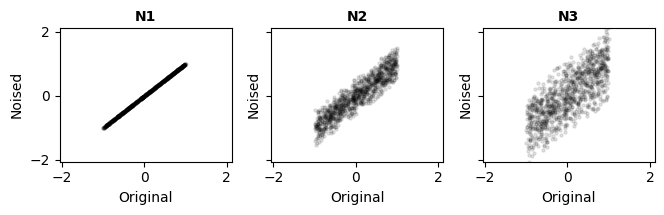

In [ ]:
synth_data = se.PickleLoad(datafolder + 'synth_data')

origo_Y = np.random.uniform(-1, 1, 1000)

y_noised = []

for inx, nx in enumerate(noise_lvls):

    noiso = scipy.stats.truncnorm.rvs(a, b, loc = my_mean, scale = my_std,
                                      size = (1000))

    synth_Y_noise = origo_Y + np.std(origo_Y) * noiso * nx

    y_noised.append([origo_Y, synth_Y_noise])

mine, maxe = se.MinMax(np.stack([x[1] for x in y_noised]))
mix = np.max([np.max(np.abs(x[1])) for x in y_noised])

sca_args = {'bounds': (mine, maxe), 'alpha': 0.1, 'pointsize': 5,
           'xlabel': 'Original', 'ylabel': 'Noised', 'color': 'black'}

noise_ids = ['N'+str(1+x) for x in np.arange(len(noise_lvls))] 

gex = 2.25

mp_args = {'plt_mode': [viz.ScaPlot, sca_args], 
           'multi': False, 'paired': False, 'transpose': False, 
           'columntitle': noise_ids,
           'sharex': True, 'sharey': True,
           'figsize': (gex * 3, gex)} 


viz.MultiPlot(y_noised, **mp_args);